## Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')


from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE
from scipy.spatial import distance
from scipy.stats import entropy

## Get sub-sampling

60


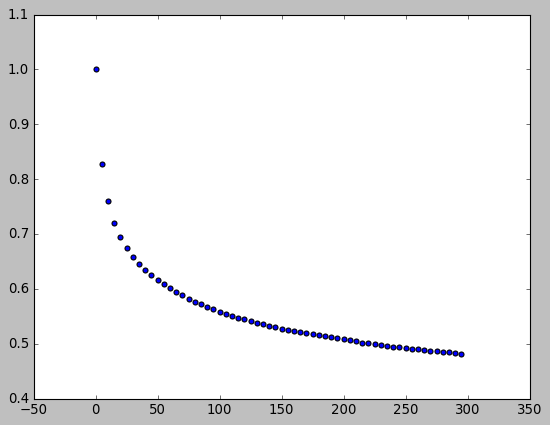

In [3]:
filename = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/sub_sampling_analysis/na_auto_MI_per_lag_6.npy'

sub_sampling = np.load(filename)
step = 5
shifts = step*np.arange(sub_sampling.shape[0])
plt.scatter(shifts, sub_sampling/np.max(sub_sampling))

auto_mi = 0.6*np.max(sub_sampling)
time_lag = np.where(np.isclose(sub_sampling, auto_mi, rtol=1e-02, atol=1e-02))
print(shifts[time_lag[0][0]])

# STORE EXPLAINED VARIANCES
explained_var = []

## Load Data - Create Dataset

In [ ]:
# loading entire high-dimensional trajectory
expm = 'normal'
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/' + expm + '/'
trajectories = os.listdir(path)

lengths = []
sub_sampling = 60
n_markers = 20
for n, traj_n in enumerate(trajectories):
    if traj_n != ".ipynb_checkpoints":
        path_n = path + traj_n + '/trajectories_na/'
        trajs = os.listdir(path_n)
        trajectory = loadmat(path_n + trajs[0])
        trajectory = trajectory['trajectory']
        
        all_trajectories = np.zeros((int(trajectory.shape[0]/sub_sampling)*len(trajs), trajectory.shape[1]))        
        for i, time_bin in enumerate(trajs):
            if time_bin != 'behavs':
                trajectory = loadmat(path_n + time_bin)
                trajectory = trajectory['trajectory'] 
                idx = np.round(np.arange(0, trajectory.shape[0], sub_sampling)).astype(int)
                trajectory = trajectory[idx]
                idx_2 = i*trajectory.shape[0]
                all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:trajectory.shape[1]] = trajectory
                
        all_trajectories = np.nan_to_num(all_trajectories)
        lengths.append(all_trajectories.shape[0])

        if n==0:
            rats = all_trajectories
            rats_enhanced = composite_dataset
        if n>0:
            rats = np.concatenate((rats, all_trajectories), axis=0)
            rats_enhanced = np.concatenate((rats_enhanced, composite_dataset), axis=0)


print(rats.shape)

nan_cols = []
for i in range(rats.shape[1]):
    if np.isnan(rats[:, i]).any():
        rats = np.nan_to_num(rats)
        cnt = np.count_nonzero(np.isnan(rats[:, i]))
        nan_cols.append(cnt)


## Dimensionality Reduction - PCA

In [ ]:
pca = PCA()
pca.fit(rats)

print('Explained variance 3 PCs:', sum(pca.explained_variance_ratio_[0:3]))

explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
plt.scatter(np.arange(rats.shape[1]), explained_var_plot)
plt.ylabel('Expalined Variance Ratio')
plt.xlabel('Dimension')

path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/dim_reduction_analysis/'
name_out = 'eigenspectrum_' + expm
plt.savefig(path_out +  name_out  + ".png")

plt.show()

In [ ]:
# reduce data according to explained variance values using linear PCA
pca = PCA(n_components=3)
reduced_traj = pca.fit_transform(rats)
name_out_2 = 'transformation_matrix_' + expm + '.npy'
print(pca.components_) 

## Whole-PCA

In [9]:
sub_sampling = 30
modes = ['normal', 'drug']
root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
# load entire high-dimensional trajectories
cnt = 0
for mode in modes:
    trajs = os.listdir(root_dir + mode + '/' )
    for traj_n in trajs:
        if traj_n != '.ipynb_checkpoints': 
            # loading entire high-dimensional trajectory
            path = root_dir + mode + '/' + traj_n + '/' + 'trajectories_na/'
            trajectories = os.listdir(path)
            # removing NaN columns
            nan_cols = []
            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs' and time_bin != '.ipynb_checkpoints':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    for i in range(trajectory.shape[1]):
                        if np.isnan(trajectory[:, i]).all():
                            nan_cols.append(i)

            # create entire trajectory
            nan_cols = np.asarray(nan_cols)
            if nan_cols.size > 0:
                if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
                    all_trajectories =  np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]-len(nan_cols)) )
            else:
                all_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]) )

            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs' and time_bin != '.ipynb_checkpoints':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    idx = np.round(np.arange(0, trajectory.shape[0], sub_sampling)).astype(int)
                    trajectory = trajectory[idx]
                    idx_2 = i*trajectory.shape[0]
                    all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:trajectory.shape[1]] = trajectory
                    
            # convert nan to number when not it is a sparse recurrence (not an entire COLUMN)
            all_trajectories = np.nan_to_num(all_trajectories)
            # lengths.append(all_trajectories.shape[0])

            # append trajectory to all trajectories
            if cnt==0:
                rats = all_trajectories
            if cnt>0:
                rats = np.concatenate((rats, all_trajectories), axis=0)
            
            cnt += 1

            print(rats.shape)

(349200, 60)
(748800, 60)
(1040400, 60)
(1314000, 60)
(1425600, 60)
(1537200, 60)
(1602000, 60)
(1713600, 60)
(1825200, 60)
(1936800, 60)
(2048400, 60)
(2160000, 60)


Explained variance 3 PCs: 0.804878208258016


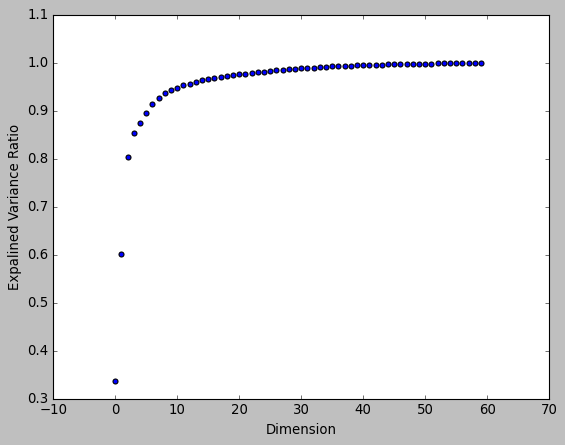

[[-0.15073236 -0.13155272  0.00897848 -0.15130266 -0.13726925  0.00504158
  -0.15304035 -0.14277411  0.00907838 -0.1587713  -0.14840718 -0.00034174
  -0.16523691 -0.15955288 -0.01509797 -0.16454263 -0.15875234 -0.02950165
  -0.16515277 -0.16259416  0.00207623 -0.16725911 -0.16612424 -0.00611586
  -0.16451498 -0.1595001  -0.0210345  -0.16252653 -0.15198293 -0.02862886
  -0.16522462 -0.16015301  0.0126598  -0.16340936 -0.15335598  0.01606653
  -0.16449741 -0.15789098  0.00961616 -0.160696   -0.14815369 -0.00289554
  -0.16055981 -0.15089208  0.00661447 -0.15979169 -0.14585211  0.00904745
  -0.16435864 -0.14936642 -0.02533549 -0.16840504 -0.16275469 -0.01965492
  -0.16738447 -0.159797   -0.01910024 -0.16316143 -0.15108753 -0.02774758]
 [-0.15002755  0.15342092  0.06171457 -0.15221623  0.15433037  0.06907181
  -0.14984049  0.14890582  0.07326348 -0.14732508  0.15746005  0.07756578
  -0.15116442  0.15586803  0.07853295 -0.13711819  0.14682051  0.06247167
  -0.15321994  0.150745    0.0798355 

In [10]:
pca = PCA()
pca.fit(rats)

print('Explained variance 3 PCs:', sum(pca.explained_variance_ratio_[0:3]))

explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
plt.scatter(np.arange(rats.shape[1]), explained_var_plot)
plt.ylabel('Expalined Variance Ratio')
plt.xlabel('Dimension')
plt.show()

pca = PCA(n_components=3)
reduced_traj = pca.fit_transform(rats)
print(pca.components_) 

In [46]:
# reduce data according to explained variance values using linear PCA
pca = PCA(n_components=3)
reduced_traj = pca.fit_transform(rats)
name_out_2 = 'transformation_matrix_full' + '.npy'